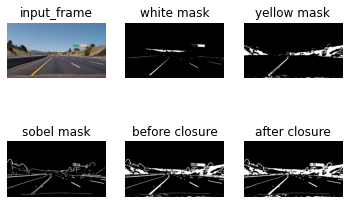

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath("hong")))))

from calibration import undistort
from _2part_utils import binarize
img = cv2.imread(r"../test1.png")

binarize(img, verbose=1)

In [2]:
# bird eye view

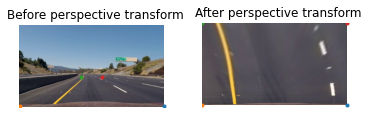

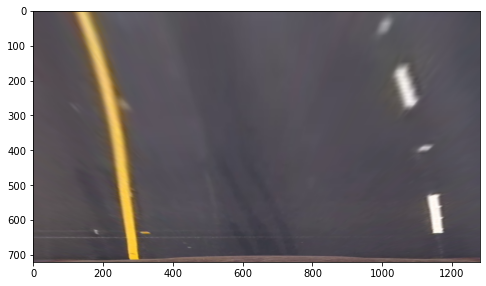

In [3]:
import pickle

with open(r"../camera_matrix.pickle", 'rb') as f:
    data = pickle.load(f)
mtx = data['mtx']
dist = data['dist']

from _2part_utils import birdeye
un_img = undistort(frame=img, mtx=mtx, dist=dist, img_plot=False)
br_img = binarize(un_img, verbose=0)
img_birdeye, M, Minv = birdeye(cv2.cvtColor(un_img, cv2.COLOR_BGR2RGB), verbose=True)

plt.figure(figsize=(8,8))
plt.imshow(img_birdeye)
plt.show()

In [4]:
# sliding window

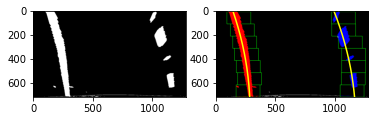

In [5]:
from calibration import undistort
from _2part_utils import binarize, get_fits_by_sliding_windows, draw_back_onto_the_road, Line
import pickle

line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)

# show result on test images

img = cv2.imread(r"../test1.png")
un_img = undistort(frame=img, mtx=mtx, dist=dist, img_plot=False)
br_img = binarize(un_img, verbose=0)
img_birdeye, M, Minv = birdeye(br_img, verbose=False)

line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, verbose=True)
blend_on_road = draw_back_onto_the_road(un_img, Minv, line_lt, line_rt, keep_state=False)

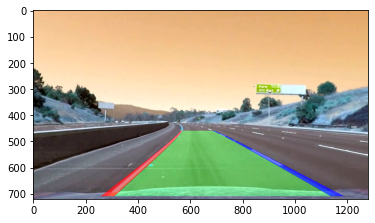

In [6]:
plt.imshow(blend_on_road)
plt.show()

In [7]:
# bird view and slicd winodw 적용

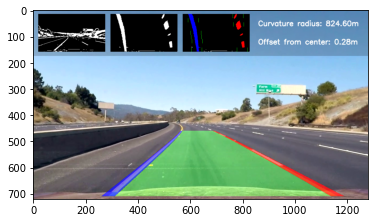

In [13]:
from _2part_utils import processed_frames, compute_offset_from_center, prepare_out_blend_frame

line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)

def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    :param frame: input color frame
    :param keep_state: if True, lane-line state is conserved (this permits to average results)
    :return: output blend with detected lane overlaid
    """

    global line_lt, line_rt, processed_frames, mtx, dist

    # undistort the image using coefficients found in calibration
    img_undistorted = undistort(frame, mtx, dist, img_plot=False)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted, verbose=False)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = birdeye(img_binary, verbose=False)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = get_fits_by_previous_fits(img_birdeye, line_lt, line_rt, verbose=False)
    else:
        line_lt, line_rt, img_fit = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=9, verbose=False)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return blend_output

# show result on test images
img = cv2.imread(r"../test1.png")
pre_img = process_pipeline(img, keep_state=False)
plt.imshow(cv2.cvtColor(pre_img, code=cv2.COLOR_BGR2RGB))
plt.show()